In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [15]:
import pandas as pd
import numpy as np
from pprint import pprint as pp

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from collections import Counter

In [18]:
from helper_methods import plot_confusion_matrices, plot_classification_report

# BACKGROUND

Two modeling areas are investigated:
- encoding of feature `soil_index`
- handling target class imbalance

### feature `soil_index`
Feature `soil_index` is non-ordinal, categorical with 40 values. Each value has a particular ecological meaning. Each value is associated with a climatic zone (7 possibilities) and a geologic zone (4 possibilities.) These zones provide a domain informed way to cluster the 40 values. The purpose of this work is to investigate how different techniques for handling this feature impact the performance of several models.

The techniques investigated are
- one-hot encoding (40 values)
- frequency encoding
- climatic zone clustering (7 values)
- geologic zone clustering (4 values)
- climatic + geologic zone clustering (11 combinations are present in the data)

These models are investigated using `pycaret`:
- logistic regression
- decision tree
- XGBoost
- LightGBM (uses categorical features directly)
- CatBoost (uses categorical features directly)

For LightGBM and CatBoost,the category values (original, climatic zone, etc.) are used directly; they are not one-hot encoded. For all other models, the original values and the cluster values are one-hot encoded. Default values are used for all hyper-parameters.   
   
### target class imbalance
There is a significant class imbalance. The 5 smallest classes are present at less than 7% each with a total of 15%. Each of these is over-sampled to increase its total count by a factor of 3. The `pycaret` functionality for including `imbalanced_learn` for over-sampling and cleaning is used.
   
The investigation of `soil_index` was completed first. Based on the performance metrics results (discussed below), the first class imbalance investigation used frequency encoding and these models (default values for all hyper-parameters):
- decision tree
- XGBoost
- CatBoost
   
Based on the performance metrics by class results (discussed below), the second class imbalance investigation used geologic zone encoding because it has the fewest clusters--4 versus 7 or 11.    

The modeling runs are in separate notebooks. This notebook contains plots of the results.

# CONCLUSIONS
### feature `soil_index`
##### performance metrics (training data)
For each model, the accuracy and weighted metrics (precision, recall, f1) are slightly better for one hot and frequency encoding. For the macro metrics, there is little difference among encoding techniques.

Decision tree has significantly better accuracy that the other models. It's other metrics, except for precision macro, are also better.

Logistic regression performs significantly worse than all other models.

The 3 remaining models generally have similar performance with the ordering of best to worse: CatBoost, XGBoost, LightGBM. No hyper-parameter tuning was done.
   
##### performance metrics by class (training data)
Precision and recall were calculated for each class. In general, the 3 cluster encoding techniques perform better for each model. (Except for logistic regression which has significantly poorer performance than all other models.) There is little difference in performance among those 3 techniques.   
   
##### training time
For models that do not directly use categorical features, one-hot takes significantly longer to train than the other encoding techniques. The other techniques take approximately the same amount of time with one-hot taking 30-40% more than this amount.   
   
The runs were done using a free GPU machine in Paperspace Gradient.
   
### target class imbalance
Work in progress.

# preamble

In [19]:
#read_csv_files = True
read_csv_files = False

# read csv files

In [20]:
if read_csv_files:
    cols_csv = ['Name', 'Accuracy', 'F1', 'F1 Macro', 'Prec', 'Precision Macro', 'Recall Macro', 'Recall Weighted', 'TT']
    cols_df = ['Name', 'Accuracy', 'Precision Macro', 'Recall Macro', 'F1 Macro', 'Prec', 'Recall Weighted', 'F1', 'TT' ]

    df_pycaret_results = pd.DataFrame()

    #encoding_list = ['one_hot', 'frequency', 'climatic_clusters', 'geologic_clusters', 'both_clusters']
    encoding_list = ['one_hot', 'frequency', 'climatic_clusters', 'geologic_clusters', 'both_clusters', 'freq_with_imblearn']

    for item in encoding_list:
        file_name = 'pycaret_results_ps/' + item + '.csv'

        df_temp = pd.read_csv(file_name, usecols=cols_csv)[cols_df]
        df_temp.dropna(inplace=True)
        #df_temp

        df_temp = df_temp.rename(columns=
                                 {'Prec':'Precision Weighted',
                                  'F1':'F1 Weighted',
                                  'TT':'Train Time, sec'
                                 })
        df_temp['Soil Encoding'] = item

        if (item.find('imblearn') > 0):
            df_temp['imblearn'] = 'yes'
        else:
            df_temp['imblearn'] = 'no'

        #df_temp

        df_pycaret_results = df_pycaret_results.append(df_temp)

    df_pycaret_results.reset_index(drop=True, inplace=True)
    df_pycaret_results

# read pickle files

In [21]:
pycaret_results_dir = 'pycaret_df_results/'

In [22]:
cover_names = ['spruce_fir', 'lodgepole_pine', 'ponderosa_pine', 'cottonwood_willow', 'aspen', 'douglas_fir', 'krummholz']
get_target_name_from_integer = lambda i : cover_names[i-1]
get_target_name_from_integer(2)

'lodgepole_pine'

In [23]:
df_pycaret_results  = pd.DataFrame()
df_results_by_class = pd.DataFrame()

### target counts

In [24]:
df_target_counts = pd.read_pickle(pycaret_results_dir + 'df_target_counts.pkl')
df_target_counts

,cover_type,count,fraction,target_name
1,1,211840,0.364605,spruce_fir
0,2,283301,0.487599,lodgepole_pine
2,3,35754,0.061537,ponderosa_pine
6,4,2747,0.004728,cottonwood_willow
5,5,9493,0.016339,aspen
4,6,17367,0.029891,douglas_fir
3,7,20510,0.035300,krummholz


### soil encoding

In [25]:
df_temp_pycaret_results  = pd.read_pickle(pycaret_results_dir + 'soil_df_pycaret_model_metrics_p4.pkl')
df_temp_results_by_class = pd.read_pickle(pycaret_results_dir + 'soil_df_report_by_class_p4.pkl')

df_temp_pycaret_results = df_temp_pycaret_results.rename(columns=
                                 {'Prec.':'Precision Weighted',
                                  'F1':'F1 Weighted',
                                  'TT (Sec)':'Train Time, sec'
                                 })
df_temp_pycaret_results['imblearn'] = 'no'
df_temp_pycaret_results

df_temp_results_by_class = df_temp_results_by_class.rename(columns={'class':'class_int'})
df_temp_results_by_class['imblearn'] = 'no'
#df_results_by_class
df_temp_results_by_class['class'] = df_temp_results_by_class['class_int'].apply(get_target_name_from_integer)
#df_temp_results_by_class
df_temp_results_by_class.drop(columns=['class_int'], inplace=True)
df_temp_results_by_class

df_pycaret_results  = df_pycaret_results.append(df_temp_pycaret_results, ignore_index=True)
df_results_by_class = df_results_by_class.append(df_temp_results_by_class, ignore_index=True)

#df_pycaret_results
#df_results_by_class

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot,no
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot,no
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot,no
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot,no
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot,no
5,Decision Tree Classifier,0.9181,0.9181,0.9181,0.9181,0.8711,0.8673,0.8692,1.6600,frequency,no
6,CatBoost Classifier,0.8820,0.8820,0.8811,0.8820,0.8790,0.8150,0.8416,78.4167,frequency,no
7,Extreme Gradient Boosting,0.8778,0.8779,0.8771,0.8778,0.8883,0.8310,0.8550,118.5633,frequency,no
8,Light Gradient Boosting Machine,0.8542,0.8540,0.8536,0.8542,0.8466,0.8091,0.8254,7.6167,frequency,no
9,Logistic Regression,0.7084,0.6919,0.6954,0.7084,0.5654,0.4325,0.4604,50.2333,frequency,no


,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
0,Decision Tree Classifier,train,0.845089,0.853527,0.849287,148628,one hot,no,spruce_fir
1,Decision Tree Classifier,train,0.857727,0.890423,0.873769,197906,one hot,no,lodgepole_pine
2,Decision Tree Classifier,train,0.796507,0.550412,0.650978,25103,one hot,no,ponderosa_pine
3,Decision Tree Classifier,train,0.562500,0.524454,0.542811,1922,one hot,no,cottonwood_willow
4,Decision Tree Classifier,train,0.768873,0.594449,0.670503,6665,one hot,no,aspen
...,...,...,...,...,...,...,...,...,...
170,Logistic Regression,train,0.659538,0.824324,0.732781,25103,both clusters,no,ponderosa_pine
171,Logistic Regression,train,0.706140,0.251301,0.370683,1922,both clusters,no,cottonwood_willow
172,Logistic Regression,train,0.000000,0.000000,0.000000,6665,both clusters,no,aspen
173,Logistic Regression,train,0.466064,0.182883,0.262687,12128,both clusters,no,douglas_fir


### imblearn with frequency encoding

In [40]:
list_file_endings = ['_xgb.pkl', '_2_models.pkl']
for item in list_file_endings:
    print(pycaret_results_dir + 'imblearn_freq_df_pycaret_model_metrics' + item)
    print(pycaret_results_dir + 'imblearn_freq_df_report_by_class' + item)

pycaret_df_results/imblearn_freq_df_pycaret_model_metrics_xgb.pkl
pycaret_df_results/imblearn_freq_df_report_by_class_xgb.pkl
pycaret_df_results/imblearn_freq_df_pycaret_model_metrics_2_models.pkl
pycaret_df_results/imblearn_freq_df_report_by_class_2_models.pkl


In [ ]:
for item in list_file_endings:
    df_temp_pycaret_results  = pd.read_pickle(pycaret_results_dir + 'imblearn_freq_df_pycaret_model_metrics' + item)
    df_temp_results_by_class = pd.read_pickle(pycaret_results_dir + 'imblearn_freq_df_report_by_class' + item)

    df_temp_pycaret_results = df_temp_pycaret_results.rename(columns=
                                     {'Prec.':'Precision Weighted',
                                      'F1':'F1 Weighted',
                                      'TT (Sec)':'Train Time, sec'
                                     })
    df_temp_pycaret_results['imblearn'] = 'yes'
    df_temp_pycaret_results['soil encoding'] = 'imblearn_freq'
    df_temp_pycaret_results

    df_temp_results_by_class = df_temp_results_by_class.rename(columns={'class':'class_int'})
    df_temp_results_by_class['imblearn'] = 'yes'
    df_temp_results_by_class['soil encoding'] = 'imblearn_freq'
    #df_results_by_class
    df_temp_results_by_class['class'] = df_temp_results_by_class['class_int'].apply(get_target_name_from_integer)
    #df_temp_results_by_class
    df_temp_results_by_class.drop(columns=['class_int'], inplace=True)
    df_temp_results_by_class

    df_pycaret_results  = df_pycaret_results.append(df_temp_pycaret_results, ignore_index=True)
    df_results_by_class = df_results_by_class.append(df_temp_results_by_class, ignore_index=True)

In [ ]:
df_pycaret_results.tail(10)
df_results_by_class.tail(10)

### imblearn with geologic zone encoding

In [41]:
list_file_endings = ['_xgb.pkl', '_2_models.pkl']
for item in list_file_endings:
    print(pycaret_results_dir + 'imblearn_geo_df_pycaret_model_metrics' + item)
    print(pycaret_results_dir + 'imblearn_geo_df_report_by_class' + item)

pycaret_df_results/imblearn_geo_df_pycaret_model_metrics_xgb.pkl
pycaret_df_results/imblearn_geo_df_report_by_class_xgb.pkl
pycaret_df_results/imblearn_geo_df_pycaret_model_metrics_2_models.pkl
pycaret_df_results/imblearn_geo_df_report_by_class_2_models.pkl


In [ ]:
for item in list_file_endings:
    df_temp_pycaret_results  = pd.read_pickle(pycaret_results_dir + 'imblearn_geo_df_pycaret_model_metrics' + item)
    df_temp_results_by_class = pd.read_pickle(pycaret_results_dir + 'imblearn_geo_df_report_by_class' + item)

    df_temp_pycaret_results = df_temp_pycaret_results.rename(columns=
                                     {'Prec.':'Precision Weighted',
                                      'F1':'F1 Weighted',
                                      'TT (Sec)':'Train Time, sec'
                                     })
    df_temp_pycaret_results['imblearn'] = 'yes'
    df_temp_pycaret_results['soil encoding'] = 'imblearn_geo'
    df_temp_pycaret_results

    df_temp_results_by_class = df_temp_results_by_class.rename(columns={'class':'class_int'})
    df_temp_results_by_class['imblearn'] = 'yes'
    df_temp_results_by_class['soil encoding'] = 'imblearn_geo'
    #df_results_by_class
    df_temp_results_by_class['class'] = df_temp_results_by_class['class_int'].apply(get_target_name_from_integer)
    #df_temp_results_by_class
    df_temp_results_by_class.drop(columns=['class_int'], inplace=True)
    df_temp_results_by_class

    df_pycaret_results  = df_pycaret_results.append(df_temp_pycaret_results, ignore_index=True)
    df_results_by_class = df_results_by_class.append(df_temp_results_by_class, ignore_index=True)

In [ ]:
df_pycaret_results.tail(10)
df_results_by_class.tail(10)

### review dataframes

In [28]:
df_pycaret_results['soil encoding'].unique()
df_pycaret_results['imblearn'].unique()
df_pycaret_results.head()
df_pycaret_results.tail()

array(['one hot', 'frequency', 'climatic clusters', 'geologic clusters',
       'both clusters'], dtype=object)

array(['no'], dtype=object)

,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot,no
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot,no
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot,no
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot,no
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot,no


,Model,Accuracy,Precision Weighted,F1 Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,"Train Time, sec",soil encoding,imblearn
20,Decision Tree Classifier,0.9127,0.9127,0.9127,0.9127,0.8624,0.8602,0.8613,1.7033,both clusters,no
21,CatBoost Classifier,0.8737,0.8737,0.8728,0.8737,0.8724,0.8050,0.8329,77.5267,both clusters,no
22,Extreme Gradient Boosting,0.8632,0.8633,0.8624,0.8632,0.8784,0.8176,0.8424,124.7133,both clusters,no
23,Light Gradient Boosting Machine,0.8465,0.8466,0.8459,0.8465,0.8337,0.7982,0.8122,6.8333,both clusters,no
24,Logistic Regression,0.7188,0.7024,0.7066,0.7188,0.5680,0.4656,0.4871,57.1967,both clusters,no


In [29]:
df_results_by_class['soil encoding'].unique()
df_results_by_class['imblearn'].unique()
df_results_by_class.head()
df_results_by_class.tail()

array(['one hot', 'frequency', 'climatic clusters', 'geologic clusters',
       'both clusters'], dtype=object)

array(['no'], dtype=object)

,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
0,Decision Tree Classifier,train,0.845089,0.853527,0.849287,148628,one hot,no,spruce_fir
1,Decision Tree Classifier,train,0.857727,0.890423,0.873769,197906,one hot,no,lodgepole_pine
2,Decision Tree Classifier,train,0.796507,0.550412,0.650978,25103,one hot,no,ponderosa_pine
3,Decision Tree Classifier,train,0.562500,0.524454,0.542811,1922,one hot,no,cottonwood_willow
4,Decision Tree Classifier,train,0.768873,0.594449,0.670503,6665,one hot,no,aspen


,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
170,Logistic Regression,train,0.659538,0.824324,0.732781,25103,both clusters,no,ponderosa_pine
171,Logistic Regression,train,0.706140,0.251301,0.370683,1922,both clusters,no,cottonwood_willow
172,Logistic Regression,train,0.000000,0.000000,0.000000,6665,both clusters,no,aspen
173,Logistic Regression,train,0.466064,0.182883,0.262687,12128,both clusters,no,douglas_fir
174,Logistic Regression,train,0.724587,0.546670,0.623179,14356,both clusters,no,krummholz


# plots: overall performance

In [30]:
def plot_soil_encoding_results(df_results, plot_time=False):
    if plot_time:
        for_plot = ['Model', 'soil encoding', 'Train Time, sec']
        ymax = df_results['Train Time, sec'].max()
        big_title = 'training time (sec) by soil encoding method'
    else:
        for_plot = df_results.columns.drop('Train Time, sec')
        ymax = 1
        big_title = 'metrics by soil encoding method'
    
    all_models = list(df_results['Model'].unique())
    num_models = len(all_models)
    
    fig, ax = plt.subplots(num_models,1)
    fig.set_figheight(20)
    fig.set_figwidth(10)
    fig.set_tight_layout({'pad':2})
    
    for i, model in enumerate(all_models):
        if plot_time:
            df_to_plot = df_results[(df_results['Model']==model) & (df_results['imblearn']=='no')][for_plot]
        else:       
            df_to_plot = df_results[(df_results['Model']==model)][for_plot]
        
        df_to_plot.set_index('soil encoding').plot.bar(ax=ax[i], legend=False)
        ax[i].set_title(model, size=20, weight=50);
        ax[i].set_xlabel('');
        ax[i].xaxis.set_tick_params(rotation=0)
        if  not plot_time:
            ax[i].set_ybound(lower=0.4, upper=1)
        
        if i == 0:
            fig.legend(bbox_to_anchor=(1.2, 0.9), loc='upper right')
    
    fig.suptitle(big_title, size=30, weight=100)
    
    plt.show

In [ ]:
plot_soil_encoding_results(df_pycaret_results)

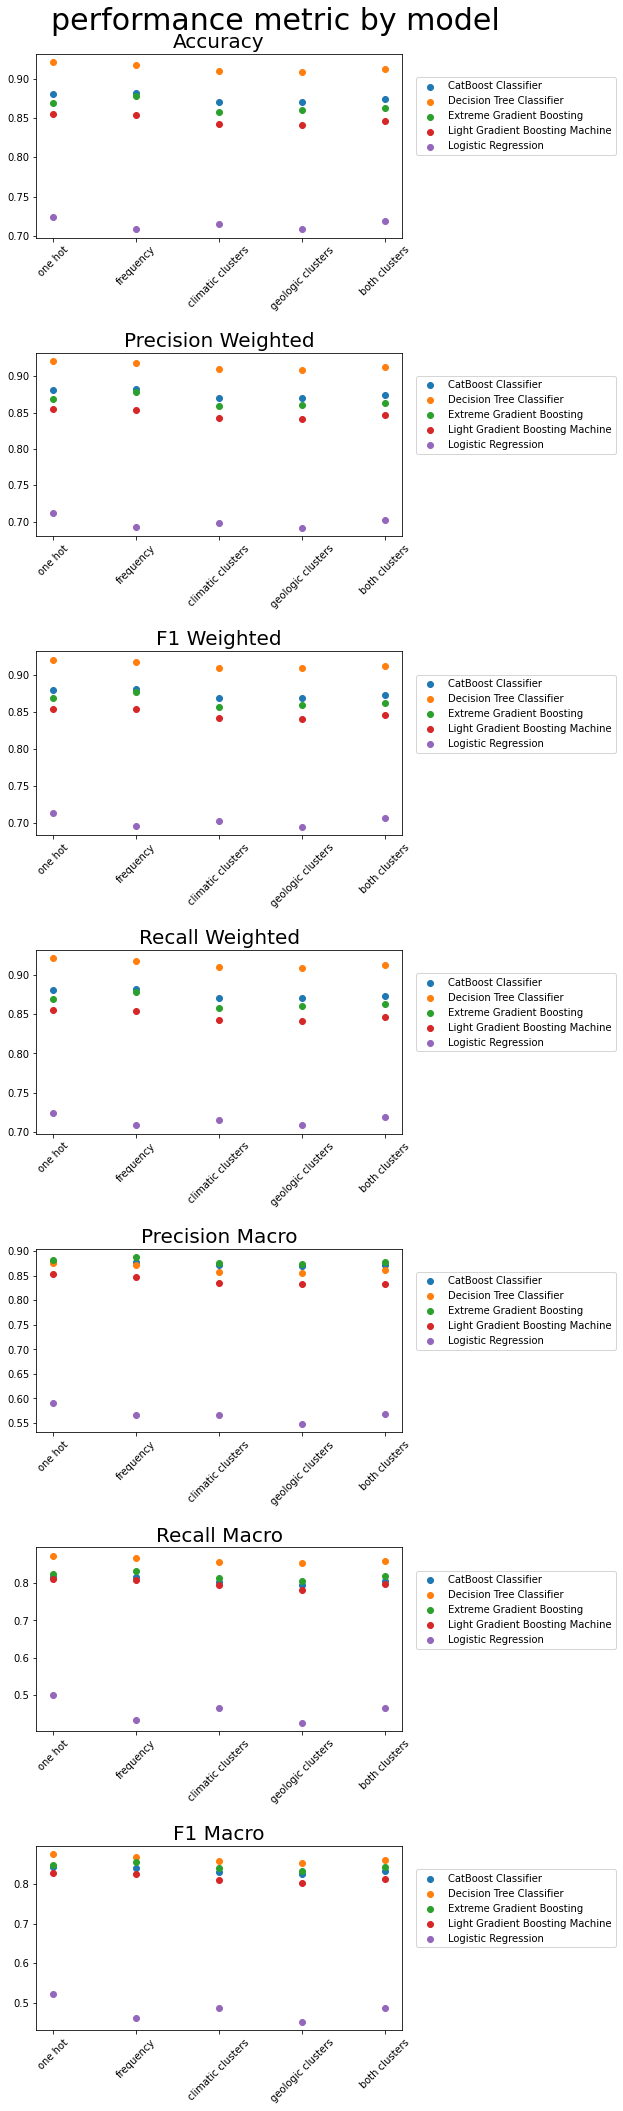

In [31]:
all_metrics = list(df_pycaret_results.columns.drop(['Model', 'soil encoding', 'imblearn', 'Train Time, sec']))

fig, ax = plt.subplots(len(all_metrics), 1)
fig.set_figheight(30)
fig.set_figwidth(8)
fig.set_tight_layout({'pad':2})

iplot = 0

for metric in all_metrics:
    df_temp = df_pycaret_results[['Model', 'soil encoding', metric]]
    #_ = plt.figure()
    
    for group, subset in df_temp.groupby('Model'):
        _ = ax[iplot].scatter(x=subset['soil encoding'], y=subset[metric], label=group)
        _ = ax[iplot].legend(bbox_to_anchor=(1.6, 0.9), loc='upper right')
        _ = ax[iplot].xaxis.set_tick_params(rotation=45)
        _ = ax[iplot].set_title(metric, size=20, weight=50)
    
    iplot += 1
    #_ = plt.show()

_ = fig.suptitle('performance metric by model', size=30, weight=100)

# plots: train time

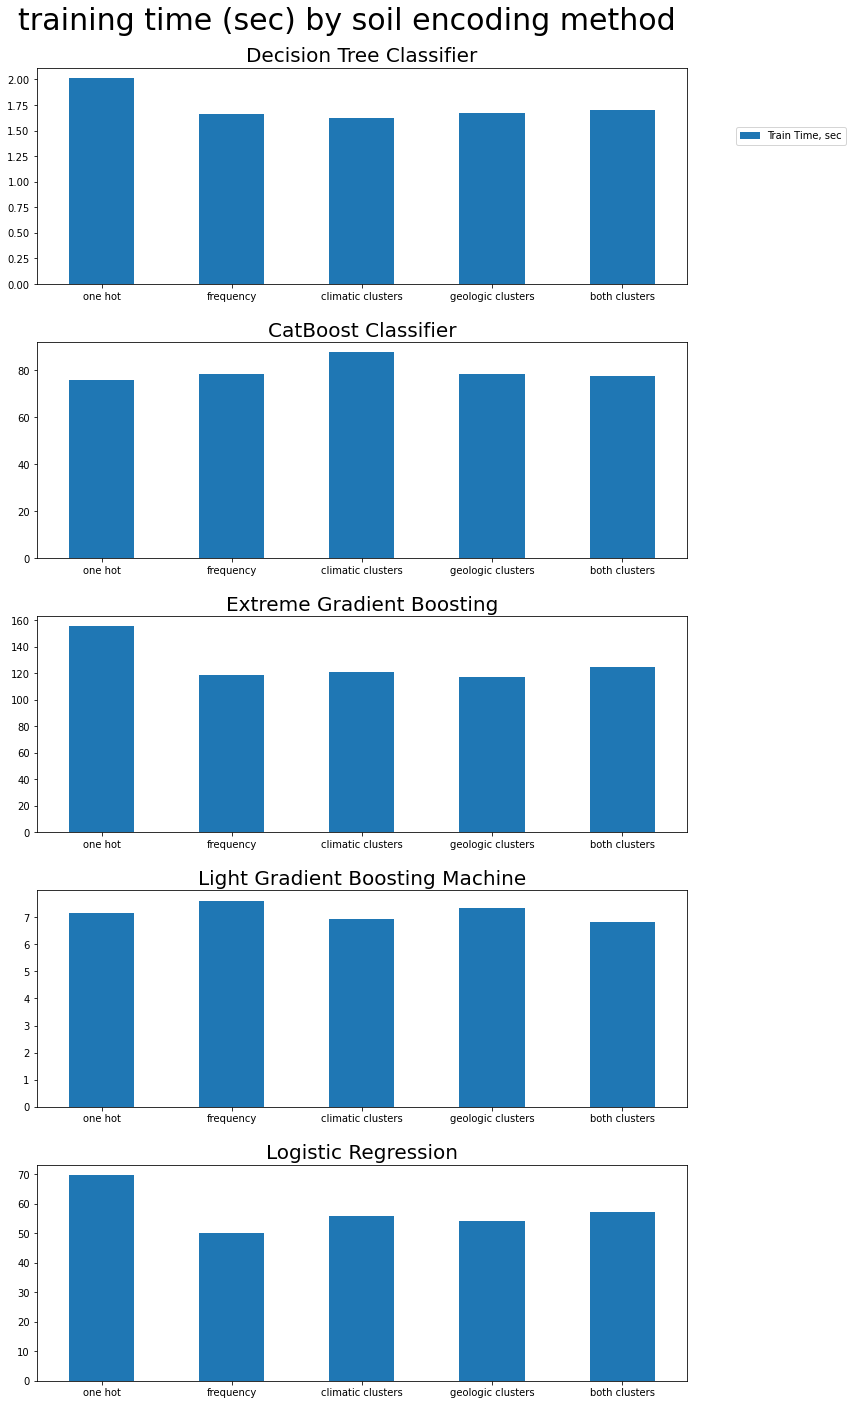

In [32]:
plot_soil_encoding_results(df_pycaret_results, plot_time=True)

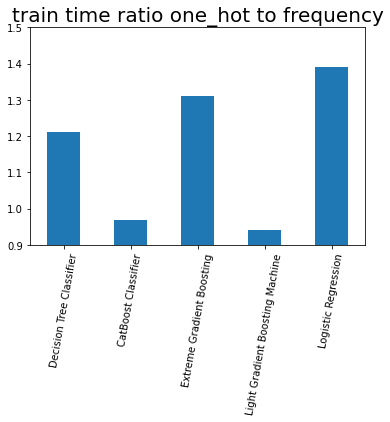

In [33]:
all_models = list(df_pycaret_results['Model'].unique())
list_model = []
list_ratio = []

for model in all_models:
    df_temp = df_pycaret_results[(df_pycaret_results['Model']==model) & (df_pycaret_results['imblearn']=='no')]
    #df_temp
    t1 = df_temp[df_temp['soil encoding']=='one hot']['Train Time, sec'].values[0]
    t2 = df_temp[df_temp['soil encoding']=='frequency']['Train Time, sec'].values[0]
    ratio = t1 / t2
    #ratio
    
    list_model.append(model)
    list_ratio.append(ratio)

df_time_ratio = pd.DataFrame({'model':list_model , 'ratio':list_ratio})
#df_time_ratio

ax = df_time_ratio.set_index('model').plot.bar(legend=False)
_ = ax.set_xlabel('')
_ = ax.xaxis.set_tick_params(rotation=80)
_ = ax.set_ybound(lower=0.9, upper=1.5)
_ = ax.set_title('train time ratio one_hot to frequency', size=20, weight=50)

# plots: performance by class

In [34]:
df_results_by_class.head()

,model,data,precision,recall,f1-score,support,soil encoding,imblearn,class
0,Decision Tree Classifier,train,0.845089,0.853527,0.849287,148628,one hot,no,spruce_fir
1,Decision Tree Classifier,train,0.857727,0.890423,0.873769,197906,one hot,no,lodgepole_pine
2,Decision Tree Classifier,train,0.796507,0.550412,0.650978,25103,one hot,no,ponderosa_pine
3,Decision Tree Classifier,train,0.562500,0.524454,0.542811,1922,one hot,no,cottonwood_willow
4,Decision Tree Classifier,train,0.768873,0.594449,0.670503,6665,one hot,no,aspen


In [35]:
df_target_counts = df_target_counts.sort_values('count', ascending=False).set_index('target_name')
df_target_counts

,cover_type,count,fraction
target_name,,,
lodgepole_pine,2,283301,0.487599
spruce_fir,1,211840,0.364605
ponderosa_pine,3,35754,0.061537
krummholz,7,20510,0.035300
douglas_fir,6,17367,0.029891
aspen,5,9493,0.016339
cottonwood_willow,4,2747,0.004728


In [36]:
df_target_counts.index.to_list()

['lodgepole_pine',
 'spruce_fir',
 'ponderosa_pine',
 'krummholz',
 'douglas_fir',
 'aspen',
 'cottonwood_willow']

In [37]:
df_target_counts.loc['aspen']['fraction']

0.016338733107061472

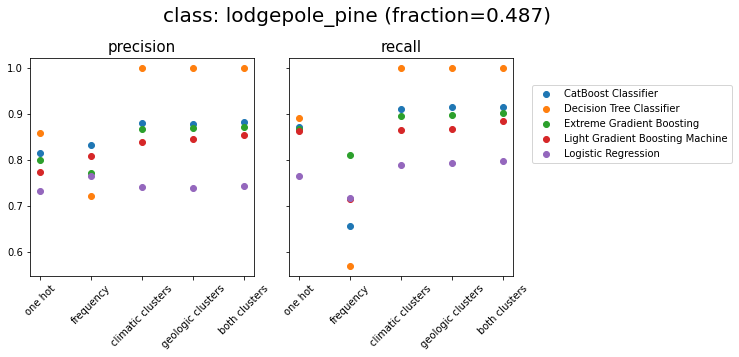

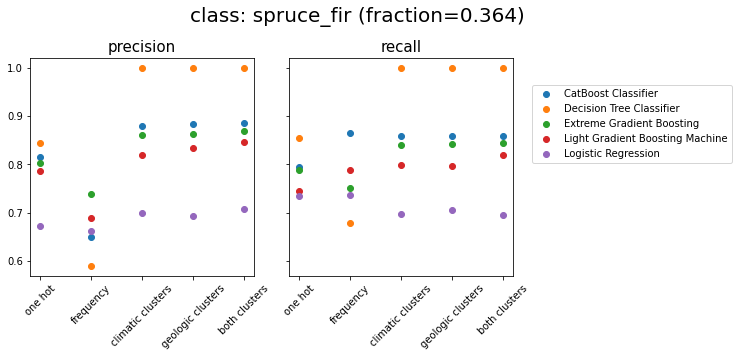

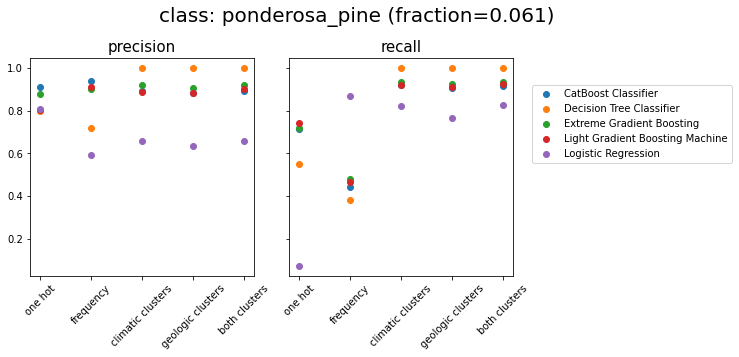

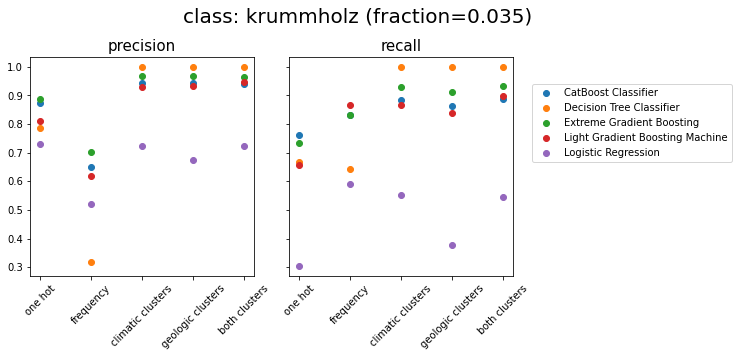

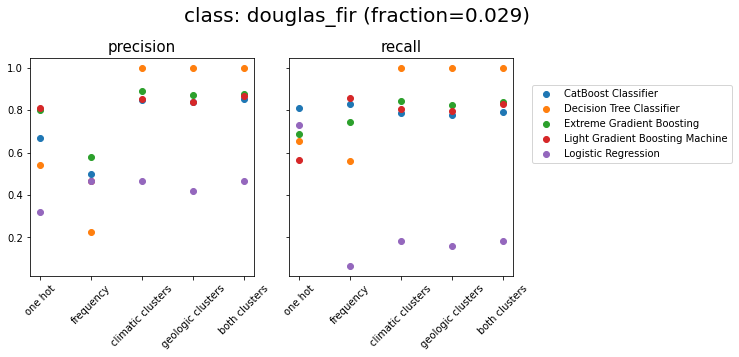

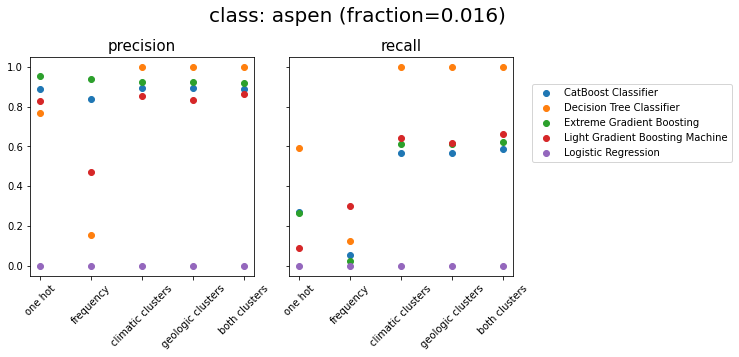

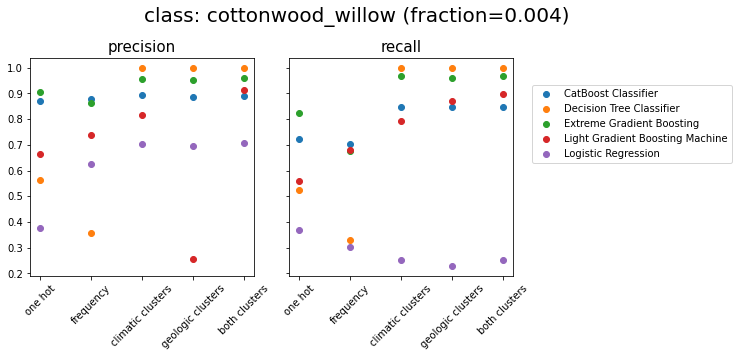

In [38]:
for the_class in df_target_counts.index.to_list():
    fraction_class = df_target_counts.loc[the_class]['fraction']
    df_one_class = df_results_by_class[df_results_by_class['class']==the_class][['model', 'soil encoding', 'precision', 'recall']]
    #df_one_class

    fig, ax = plt.subplots(1, 2, sharey=True)
    _ = fig.set_figheight(5)
    _ = fig.set_figwidth(10)
    _ = fig.suptitle('class: ' + the_class + ' (fraction=' + str(fraction_class)[:5] + ')', size=20, weight=100)
    _ = fig.set_tight_layout({'pad':1})

    for group, subset in df_one_class.groupby('model'):
        _ = ax[0].scatter(x=subset['soil encoding'], y=subset['precision'], label=group)
        _ = ax[0].xaxis.set_tick_params(rotation=45)
        #_ = ax[0].legend()
        _ = ax[0].set_title('precision', size=15, weight=50)

        _ = ax[1].scatter(x=subset['soil encoding'], y=subset['recall'], label=group)
        _ = ax[1].xaxis.set_tick_params(rotation=45)
        _ = ax[1].legend(bbox_to_anchor=(2.0, 0.9), loc='upper right')
        _ = ax[1].set_title('recall', size=15, weight=50)

# write pickle

In [ ]:
#df_soil_encoding_results.to_pickle('data/soil_encoding_pycaret_results_large.pkl')